# Dataset Normalization 

- How is a dataset normalized?
    - Taking data points and transforming them into encoded formats
    - Feature scaling
    - Transforming to similar scales
- How does dataset normalization affect the training process?
    - If you have features of a different scale, such as age and weight, it would be useful to normalize the two such that they are on similar scales
    - This is done by some sort of encoding transformations
    
## Standardization

- A normalization process 
<blockquote>Data standardization is a specific type of normalization technique. It is sometimes referred to as z-score normalization. The z-score, a.k.a. standard score, is the transformed value for each data point.</blockquote>
    Formula: $z = \frac{x - mean}{std}$
    In other words words: 
- Sometimes we have to calculate mean and standard deviation beforehand before we can standardize the dataset

In [1]:
import my_model

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import time
from collections import OrderedDict, namedtuple
from itertools import product

import pandas as pd
import json

from IPython.display import clear_output


In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./Documents/data'
     ,train=True
    ,download=True # downloads it locally (checks existence beforehand)
    ,transform=transforms.Compose([
        transforms.ToTensor() # butilt in tensor transformer
        # TODO: Normalize
    ])
)

In [3]:
# Method one
run_start_time = time.time()
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std(), (time.time() - run_start_time)

(tensor(0.2859), tensor(0.3530), 5.241843938827515)

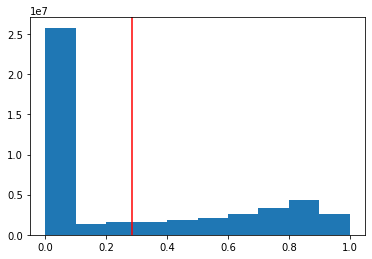

In [4]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean(),color='r')

#### Data Might not Fit in Memory to be Loaded at Once

- In this case, we need to caculate the mean and std using batches 

In [5]:
# Method Two
run_start_time = time.time()
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)

num_of_pixels = len(train_set) * 28 * 28

total_sum = 0
for batch in loader:
    total_sum += batch[0].sum()

mean = total_sum / num_of_pixels

sum_of_squared_error = 0

for batch in loader:
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
    
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

mean, std, (time.time() - run_start_time)

(tensor(0.2859), tensor(0.3514), 9.68764615058899)

#### Using the **mean** and **std** values

- Transform the data using the standardization method mentioned earlier

In [6]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./Documents/data'
     ,train=True
    ,download=True # downloads it locally (checks existence beforehand)
    ,transform=transforms.Compose([
        transforms.ToTensor(), # butilt in tensor transformer
        # TODO: Normalize
        transforms.Normalize(mean, std)
    ])
)

#### Taking a look at the new mean and standard deviation

- The mean should be (very) close to zero and the std to one

In [7]:
# Method one
run_start_time = time.time()
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std(), (time.time() - run_start_time)

(tensor(0.2859), tensor(0.3530), 5.097594738006592)

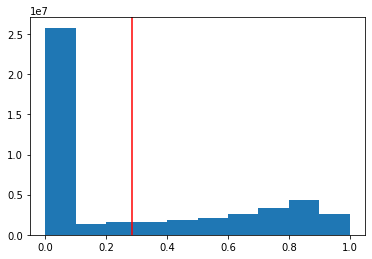

In [8]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean(),color='r')

#### Training with the normalized dataset

- We will be using the RunManager and the RunBuilder

In [9]:
params = OrderedDict(
    lr = [.01],
    batch_size = [1000],
    num_workers = [1],
    device = ['cpu'],
    trainset = ['not_normal', 'normal']
)

trainsets = {
    'not_normal': train_set,
    'normal': train_set_normal
}


In [10]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple('Run', params.keys())
        
        runs = []
        
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

class RunManager():
    def __init__(self):
        
        # we will need to extract a class out of these epoch values
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
        
    def begin_run(self, run, network, loader):
        
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        
        for k,v in self.run_params._asdict().items():
            results[k] = v
        
        self.run_data.append(results)
        
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        
        clear_output(wait=True)
        display(df)
        
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
        
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        # underscore indicates that this method should not really 
        # be used outside this class
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self,fileName):
        
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns',
        ).to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [11]:
#from my_model import RunManager
#import time
m = RunManager()

for run in RunBuilder.get_runs(params):
    
    network = my_model.Network()
    
    loader = DataLoader(trainsets[run.trainset], 
                        batch_size=run.batch_size, 
                        num_workers=run.num_workers)
    
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            
            images = batch[0]
            labels = batch[1]
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
0,1,1,1.076148,0.587733,11.230671,19.796728,0.01,1000,1,cpu,not_normal
1,1,2,0.604429,0.764967,11.334750,31.233520,0.01,1000,1,cpu,not_normal
2,1,3,0.501449,0.811633,10.050253,41.358600,0.01,1000,1,cpu,not_normal
3,1,4,0.447519,0.835317,10.306862,51.732854,0.01,1000,1,cpu,not_normal
4,1,5,0.417670,0.845317,9.693973,61.490840,0.01,1000,1,cpu,not_normal
5,2,1,0.810447,0.692367,9.785132,10.048035,0.01,1000,1,cpu,normal
6,2,2,0.440103,0.836300,10.526845,20.640422,0.01,1000,1,cpu,normal
7,2,3,0.362087,0.866683,9.533041,30.239516,0.01,1000,1,cpu,normal
8,2,4,0.328412,0.878417,9.327516,39.632897,0.01,1000,1,cpu,normal
9,2,5,0.304781,0.887217,9.154029,48.851036,0.01,1000,1,cpu,normal


In [12]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
9,2,5,0.304781,0.887217,9.154029,48.851036,0.01,1000,1,cpu,normal
8,2,4,0.328412,0.878417,9.327516,39.632897,0.01,1000,1,cpu,normal
7,2,3,0.362087,0.866683,9.533041,30.239516,0.01,1000,1,cpu,normal
4,1,5,0.417670,0.845317,9.693973,61.490840,0.01,1000,1,cpu,not_normal
6,2,2,0.440103,0.836300,10.526845,20.640422,0.01,1000,1,cpu,normal
3,1,4,0.447519,0.835317,10.306862,51.732854,0.01,1000,1,cpu,not_normal
2,1,3,0.501449,0.811633,10.050253,41.358600,0.01,1000,1,cpu,not_normal
1,1,2,0.604429,0.764967,11.334750,31.233520,0.01,1000,1,cpu,not_normal
5,2,1,0.810447,0.692367,9.785132,10.048035,0.01,1000,1,cpu,normal
0,1,1,1.076148,0.587733,11.230671,19.796728,0.01,1000,1,cpu,not_normal


## Conclusion

- Data normalization (in this data set at least) gets us a higher accuracy faster

# Resources
- https://www.youtube.com/watch?v=lu7TCu7HeYc&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=36&ab_channel=deeplizard